In [1]:
# Import libraries
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
plt.rcParams.update({'font.size': 16})

%matplotlib inline

# 1. Load Simulation Results

In [2]:
# All simulation temperatures
simulation_temps = [round(0.25*i, 2) for i in range(0, 8, 1)] + [round(0.05*i, 2) for i in range(40, 60, 1)] + [round(0.25*i, 2) for i in range(12, 21, 1)]

# Load all results
sim_results = dict()
for current_temp in simulation_temps:
    sim_results[current_temp] = dict(np.load(f"results/temp_{current_temp}_p.npz"))

# 2. Compute Auto-Correlation Time

In [3]:
# Define auto-correlation function for
# numpy arrays using numpy function
def autocorr(x, max_lag):
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in range(max_lag)]
    return np.array(corr)

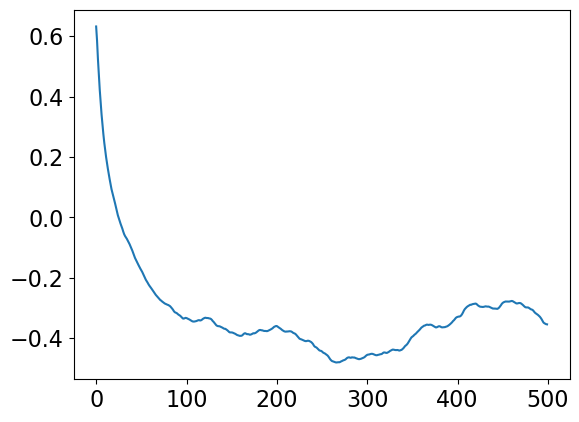

In [4]:
current_temp = 2.2
abs_magnet = abs(sim_results[current_temp]["hist_magnetization"]) / sim_results[current_temp]["lattice_size"]**2
plt.plot(autocorr(abs_magnet[15000:], 500) - np.exp(-1))

d:\Coding-IDEs\anaconda3\envs\dl_flwr\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


ELSE_CASE
ELSE_CASE
ELSE_CASE
ELSE_CASE


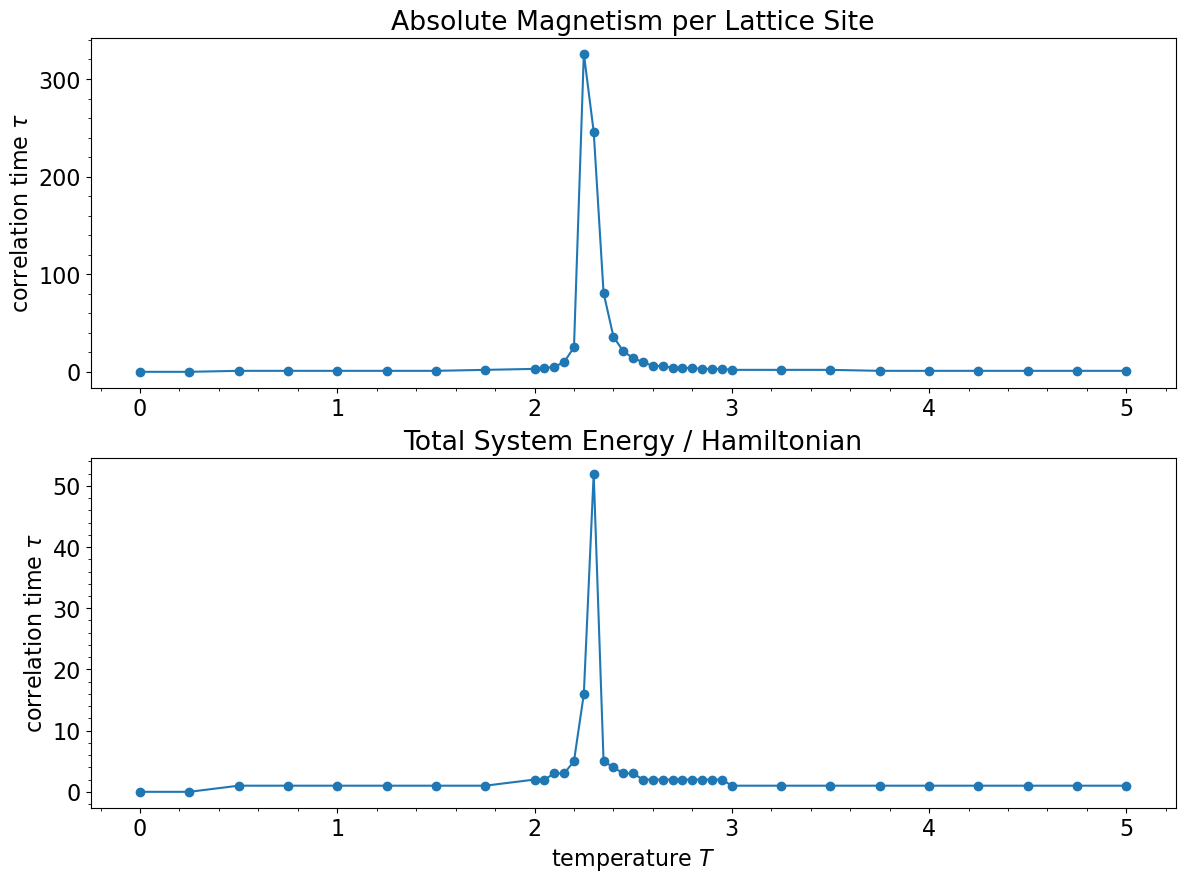

In [5]:
magnet_correlation = []
energy_correlation = []
for current_temp in simulation_temps:
    # Extract magnetization and energy results
    abs_magnet = abs(sim_results[current_temp]["hist_magnetization"]) / sim_results[current_temp]["lattice_size"]**2
    total_energy = sim_results[current_temp]["hist_total_engery"]
    # Compute auto-correlation
    corr1 = autocorr(abs_magnet[15000:], 500) - np.exp(-1)
    corr2 = autocorr(total_energy[15000:], 500) - np.exp(-1)
    # Append results to lists
    valid = np.argwhere(corr1 < 0)
    if len(valid) > 0:
        magnet_correlation.append(valid[0][0])
    else:
        print("ELSE_CASE")
        magnet_correlation.append(0)
    valid = np.argwhere(corr2 < 0)
    if len(valid) > 0:
        energy_correlation.append(valid[0][0])
    else:
        print("ELSE_CASE")
        energy_correlation.append(0)

# Create figure and plots
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel(r"temperature $T$")

# Plot correlation time for Magnetization
ax1 = fig.add_subplot(211)
ax1.set_title('Absolute Magnetism per Lattice Site')
ax1.scatter(simulation_temps, magnet_correlation)
ax1.plot(simulation_temps, magnet_correlation)
ax1.set_ylabel(r"correlation time $\tau$")
ax1.minorticks_on()

# Plot correlation time for Energy
ax2 = fig.add_subplot(212)
ax2.set_title('Total System Energy / Hamiltonian')
ax2.scatter(simulation_temps, energy_correlation)
ax2.plot(simulation_temps, energy_correlation)
ax2.set_ylabel(r"correlation time $\tau$")
ax2.minorticks_on()

plt.savefig("figures/correlation.pdf", bbox_inches='tight', dpi=300)

# 3. Compute Ergodic Average

### a) Absolute Magnetization

In [6]:
average_magnetizations = []
sampled_magnetizations = []
for indx, current_temp in enumerate(simulation_temps):
    # Extract Results
    abs_magnet = abs(sim_results[current_temp]["hist_magnetization"]) / sim_results[current_temp]["lattice_size"]**2
    slice_step = 1 if magnet_correlation[indx] == 0 else (2 * magnet_correlation[indx])
    sampled_magnetizations.append(abs_magnet[15_000::slice_step])
    average_magnetizations.append(np.mean(sampled_magnetizations[-1]))

### b) Total Energy

In [7]:
average_energy = []
sampled_energy = []
for indx, current_temp in enumerate(simulation_temps):
    # Extract Results
    system_energy = sim_results[current_temp]["hist_total_engery"]
    slice_step = 1 if energy_correlation[indx] == 0 else (2 * energy_correlation[indx])
    sampled_energy.append(system_energy[15_000::slice_step])
    average_energy.append(np.mean(sampled_energy[-1]))

# 4. Compute Error by $\pm\frac{\;2\sigma}{\sqrt{N}}$

In [8]:
# Helper function to compute standard deviation
def compute_std(samples, mean, tau, t_max):
    return math.sqrt(2 * tau * (np.mean(np.power(samples, 2)) - (mean**2)) / t_max)

### a) Absolute Magnetization

In [9]:
# Compute Errors at all temperatures
magnetization_sds = []
for indx, (samples, mean) in enumerate(zip(sampled_magnetizations, average_magnetizations)):
    magnetization_sds.append(compute_std(samples=samples, mean=mean, tau=magnet_correlation[indx], t_max=25_000))

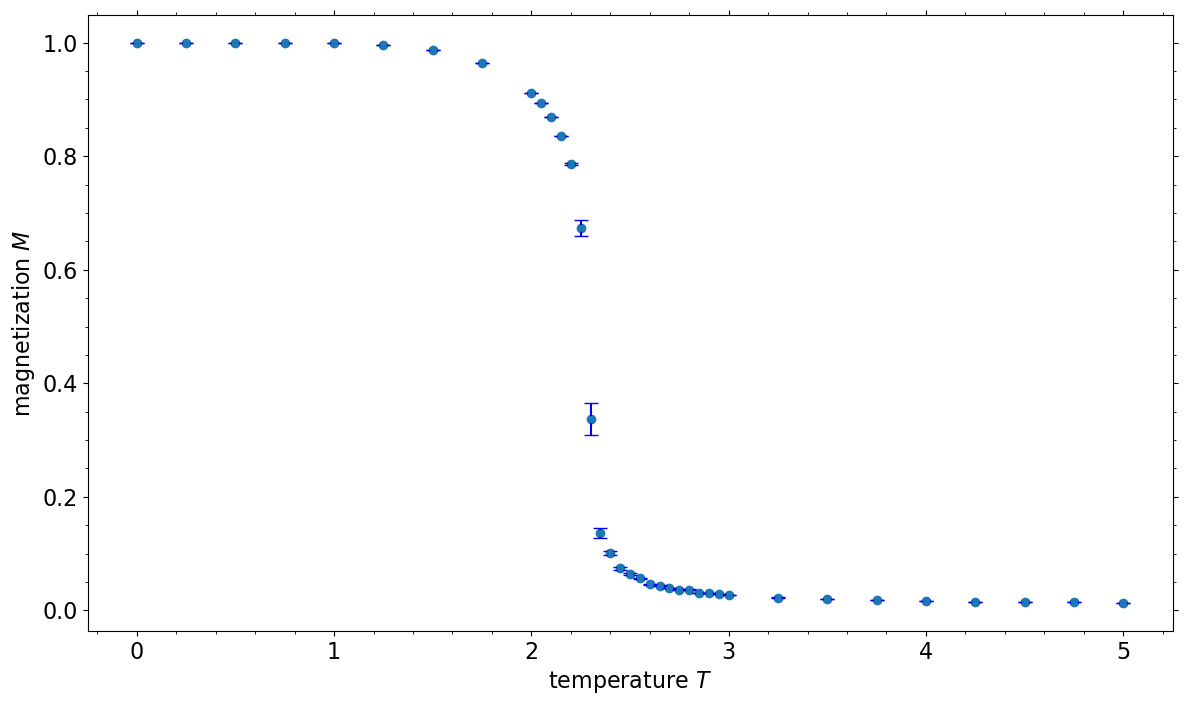

In [10]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.scatter(simulation_temps, average_magnetizations)
#ax.plot(simulation_temps, average_magnetizations, marker="o", color="blue")
ax.errorbar(simulation_temps, average_magnetizations, magnetization_sds, fmt=".", markersize=8, capsize=5, ecolor="blue")

ax.tick_params(which="both", direction="out", labelcolor='black', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()

ax.set_xlabel(r"temperature $T$")
ax.set_ylabel(r"magnetization $M$")

plt.savefig("figures/error_estimate_magnetization.pdf", bbox_inches='tight', dpi=300)

### b) Total Energy

In [11]:
# Helper function to compute standard deviation
def compute_std(samples, mean, tau, t_max):
    return math.sqrt(np.mean(np.power(samples, 2)) - (mean**2))

In [12]:
# Compute Errors at all temperatures
energy_sds = []
for indx, (samples, mean) in enumerate(zip(sampled_energy, average_energy)):
    energy_sds.append(compute_std(samples=samples, mean=mean, tau=energy_correlation[indx], t_max=25_000))

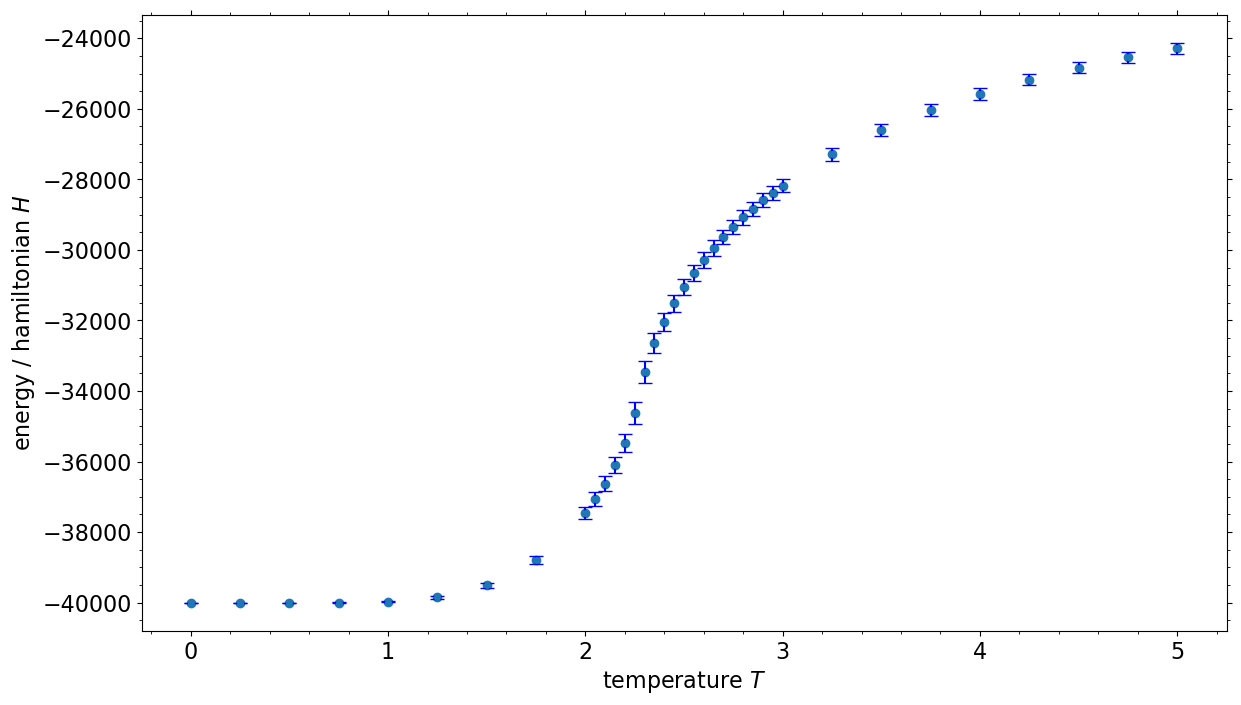

In [13]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.scatter(simulation_temps, average_energy)
ax.errorbar(simulation_temps, average_energy, energy_sds, fmt=".", markersize=8, capsize=5, ecolor="blue")

ax.tick_params(which="both", direction="out", labelcolor='black', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()

ax.set_xlabel(r"temperature $T$")
ax.set_ylabel(r"energy / hamiltonian $H$")

plt.savefig("figures/error_estimate_energy.pdf", bbox_inches='tight', dpi=300)

# 5. Investigate $M$ as a function of $T$

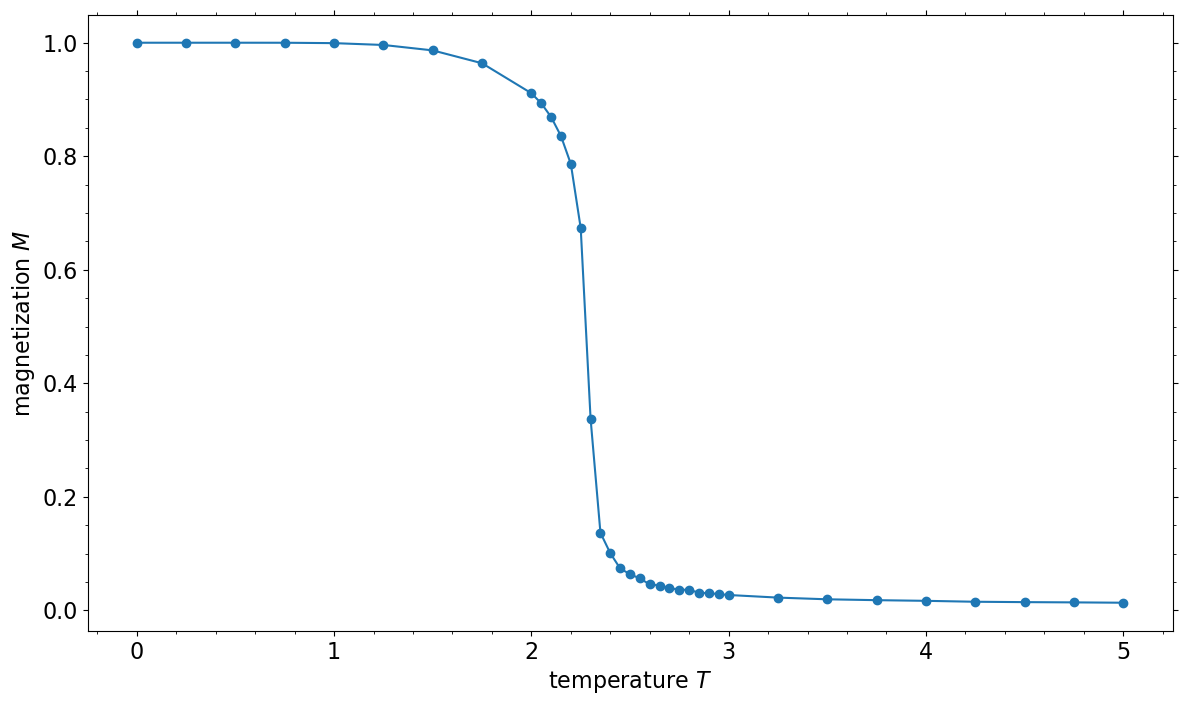

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.scatter(simulation_temps, average_magnetizations)
ax.plot(simulation_temps, average_magnetizations)
ax.tick_params(which="both", direction="out", labelcolor='black', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()

ax.set_xlabel(r"temperature $T$")
ax.set_ylabel(r"magnetization $M$")

plt.savefig("figures/magnetizations.pdf", bbox_inches='tight', dpi=300)

# 6. Investigate $H$ as a function of $T$

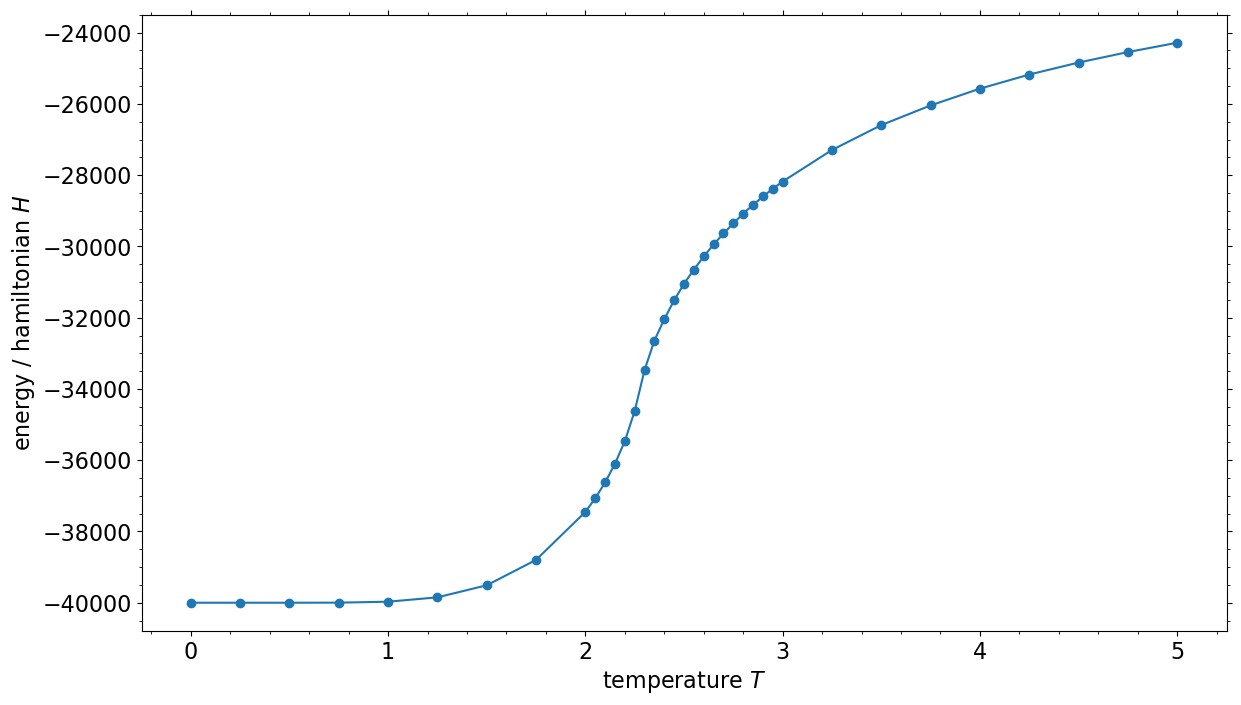

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.scatter(simulation_temps, average_energy)
ax.plot(simulation_temps, average_energy)
ax.tick_params(which="both", direction="out", labelcolor='black', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()

ax.set_xlabel(r"temperature $T$")
ax.set_ylabel(r"energy / hamiltonian $H$")

plt.savefig("figures/energy.pdf", bbox_inches='tight', dpi=300)

# 7. Plot Lattice and Create GIF:

In [16]:
# cmap = matplotlib.colors.ListedColormap(["Red", "Green"])
# fig_plot, ax_plot = plt.subplots(1, 1, figsize=(24, 8))

# # Clear all axis
# for current_temp in simulation_temps:
#     for lattice in sim_results[current_temp]["hist_lattices"][::1000]:
#         ax_plot.clear()
#         ax_plot.imshow(lattice, interpolation="None", cmap=cmap, vmin=-1, vmax=1)
#         plt.pause(0.05)
#     print(f"DONE! {current_temp}")

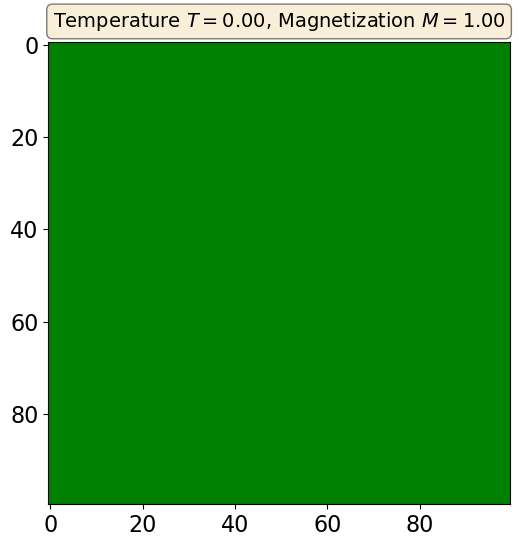

In [19]:
cmap = matplotlib.colors.ListedColormap(["Red", "Green"])
fig, ax = plt.subplots(figsize=(6, 6))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def animate(i):
    temp_T = simulation_temps[i // 25_000]
    magn_M = abs(sim_results[temp_T]["hist_magnetization"][i%25_000]) / sim_results[temp_T]["lattice_size"]**2
    lattic = sim_results[temp_T]["hist_lattices"][i%25_000]
    textstr = r"Temperature $T = $"+f"{temp_T:0.2f}, Magnetization " + "$M = $" + f"{magn_M:0.2f}"
    ax.clear()
    ax.text(0.01, 1.07, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.imshow(lattic, interpolation="None", cmap=cmap, vmin=-1, vmax=1)

ani = FuncAnimation(fig, animate, interval=200, blit=False, repeat=False, frames=range(0, len(simulation_temps)*25_000, 2_500))
ani.save("figures/lattice.gif", dpi=200, writer=PillowWriter(fps=50))